In [ ]:
!pip install yake
!pip install geopandas
!pip install contextily
!pip install shapely
!pip install geodatasets

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk

from google.colab import drive
drive.mount('/content/drive/')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.2/60.2 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 356.9/356.9 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 79.8 MB/s eta 0:00:00
Mounted at /content/drive/


In [ ]:
rider_data = '/content/drive/MyDrive/Text_as_Data_Project/ridership_aggregated.csv'

#rider_data = '/content/ridership_aggregated.csv'
tweet_data = '/content/drive/MyDrive/Text_as_Data_Project/tweets_with_final_sentiment.csv'
#tweet_data = '/content/tweets_with_final_sentiment.csv'

df_mta = pd.read_csv(rider_data)
df_tweets = pd.read_csv(tweet_data)
df_tweets.head(5)
df_tweets = df_tweets[['cleaned','Comments','Retweets','Likes','Analytics','Date','vader_score','negative','neutral','positive','nlp_sentiment_normalized', 'overall_sentiment']]
df_tweets['net_sentiment'] = df_tweets['positive'] - df_tweets['negative']

In [ ]:
df_tweets.head(5)

#some dates have a LOT of data that is from irrelevant accounts (removed during processing)

cleaned Comments Retweets Likes  \
0                           new york subway restless        0        0     1   
1  everyone deserves chance fly taken shuttle see...        1        2     7   
2                             whats going nyc subway        0        0     1   
3                                   wbb game 1pm mta        0        0     0   
4                                  loving nyc subway        0        0     0   

  Analytics        Date  vader_score  negative   neutral  positive  \
0        28  2024-11-10      -0.2732  0.184088  0.775679  0.040233   
1      1.2K  2024-11-10       0.2500  0.026302  0.580260  0.393438   
2       160  2024-11-10       0.0000  0.035926  0.888815  0.075259   
3       108  2024-11-10       0.0000  0.053594  0.828768  0.117638   
4        56  2024-11-10       0.5994  0.006608  0.171279  0.822113   

   nlp_sentiment_normalized  overall_sentiment  net_sentiment  
0                 -0.151262          -0.212231      -0.143855  
1                  0.367033           0.308516       0.367136  
2                  0.034545           0.017272       0.039333  
3                  0.059609           0.029805       0.064044  
4                  0.821810           0.710605       0.815505

<ipython-input-5-e88bdabc43c2>:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  info_df = pd.concat([info_df, pd.DataFrame([new_row])], ignore_index=True)


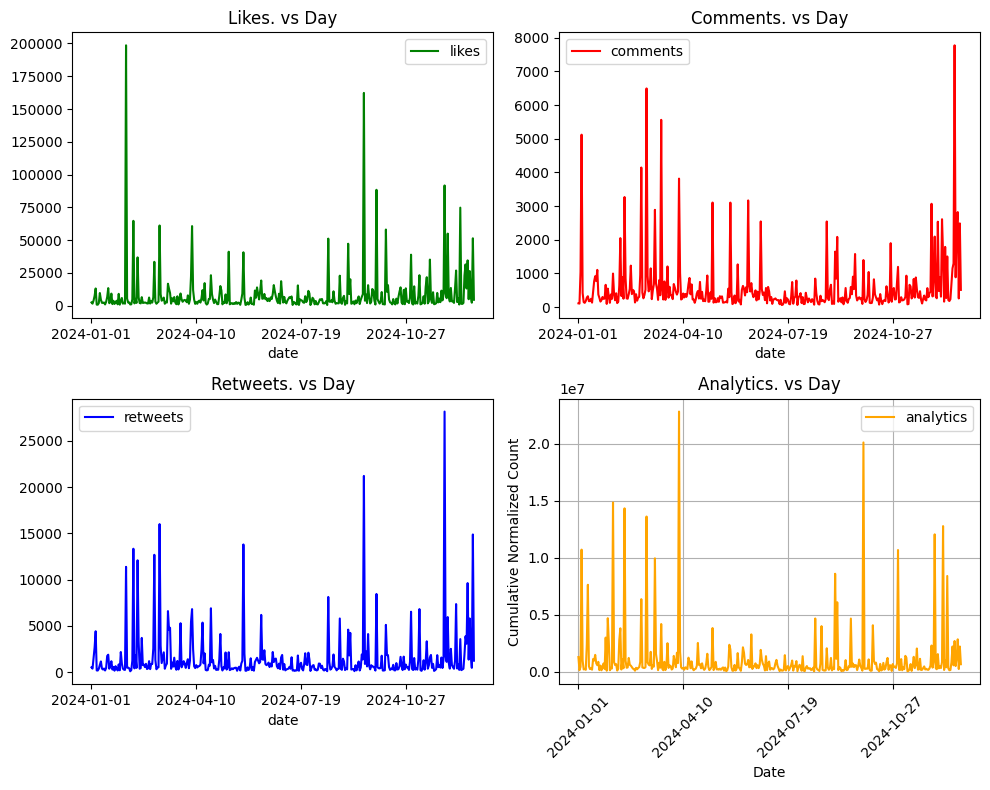

In [ ]:

# Group by Date and sum metrics

cols = ['Comments', 'Retweets', 'Likes', 'Analytics']

for col in cols:
    new_values = []
    for item in df_tweets[col]:
        item_str = str(item).strip()
        if item_str.endswith('K'):
            num = float(item_str[:-1]) * 1_000
        elif item_str.endswith('M'):
            num = float(item_str[:-1]) * 1_000_000
        else:
            num = float(item_str)

        new_values.append(num)

    df_tweets[col] = new_values



info_df = pd.DataFrame(columns=['date', 'likes','comments','retweets','analytics'])

def normalize_100(df):
  if len(df) == 100:
    return df.sum()
  else:
    return df.sum()*100/len(df)

for date in df_tweets['Date'].unique():
  daily_comms = normalize_100(df_tweets[df_tweets['Date'] == date].Comments)
  daily_retweets = normalize_100(df_tweets[df_tweets['Date'] == date].Retweets)
  daily_analytics = normalize_100(df_tweets[df_tweets['Date'] == date].Analytics)
  daily_likes = normalize_100(df_tweets[df_tweets['Date'] == date].Likes)
  new_row = {'date': date, 'likes': daily_likes, 'comments': daily_comms, 'retweets': daily_retweets, 'analytics': daily_analytics}
  info_df = pd.concat([info_df, pd.DataFrame([new_row])], ignore_index=True)


info_df_timeseries = info_df.sort_values(by='date')

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

info_df_timeseries.plot(x='date', y='likes', kind='line',ax=axes[0, 0], title='Likes. vs Day', color='green')
info_df_timeseries.plot(x='date', y='comments', kind='line',ax=axes[0, 1], title='Comments. vs Day', color='red')
info_df_timeseries.plot(x='date', y='retweets', kind='line',ax=axes[1, 0], title='Retweets. vs Day', color='blue')
info_df_timeseries.plot(x='date', y='analytics', kind='line',ax=axes[1, 1], title='Analytics. vs Day', color='orange')

# Plot data on different subplots
plt.xlabel('Date')
plt.ylabel('Cumulative Normalized Count')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
info_df_timeseries

date         likes     comments      retweets     analytics
7    2024-01-01   2468.750000   109.375000    513.541667  1.309522e+06
32   2024-01-02   1537.113402   102.061856    374.226804  1.545474e+05
40   2024-01-03   3939.130435  1040.217391   1483.695652  4.546641e+05
67   2024-01-04   7466.000000  5122.000000   2661.000000  1.072420e+07
87   2024-01-05  13113.541667   416.666667   4415.625000  1.004939e+06
..          ...           ...          ...           ...           ...
167  2024-12-27  26413.541667  2471.875000   5800.000000  1.263809e+06
206  2024-12-28   7821.505376  2821.505376   2126.881720  2.861301e+06
220  2024-12-29   2276.666667   255.555556    460.000000  2.580833e+05
141  2024-12-30  51398.913043  2485.869565  14883.695652  2.233334e+06
157  2024-12-31   4485.416667   509.375000   1231.250000  6.789604e+05

[366 rows x 5 columns]

In [ ]:
# identifying 'spike' points of discourse: we take the dates which have the top 10 percentile of interactions

from collections import Counter

top_likes = info_df_timeseries.nlargest(36, 'likes')['date'].tolist()
top_comments = info_df_timeseries.nlargest(36, 'comments')['date'].tolist()
top_retweets = info_df_timeseries.nlargest(36, 'retweets')['date'].tolist()
top_analytics = info_df_timeseries.nlargest(36, 'analytics')['date'].tolist()

top_all = 3*top_likes + 3*top_comments +  2*top_retweets + 1*top_analytics
top_unique_all = list(set(top_all))
top_all_freq = {i:top_all.count(i) for i in set(top_all)}
top_across = Counter(top_all_freq).most_common(10)
top_across = [item[0] for item in top_across]


In [ ]:
df_tweets.columns

Index(['cleaned', 'Comments', 'Retweets', 'Likes', 'Analytics', 'Date',
       'vader_score', 'negative', 'neutral', 'positive',
       'nlp_sentiment_normalized', 'overall_sentiment', 'net_sentiment'],
      dtype='object')

In [ ]:
df_tweets_sentiment = df_tweets[['cleaned','Date','vader_score','nlp_sentiment_normalized','overall_sentiment']]
df_tweets_sentiment.rename(columns={'cleaned':'tweet','Date':'date','vader_score':'VADER_score','nlp_sentiment_normalized':'BERT_score'}, inplace=True)
df_tweets_sentiment = df_tweets_sentiment.sort_values(by='date')
df_tweets_sentiment

<ipython-input-9-f855d5a889d8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tweets_sentiment.rename(columns={'cleaned':'tweet','Date':'date','vader_score':'VADER_score','nlp_sentiment_normalized':'BERT_score'}, inplace=True)


tweet        date  \
699                         happy new year bf threw uggs  2024-01-01   
741    nycdsa state electeds led way block hector las...  2024-01-01   
740        new york mta issues rfi new modern fare gates  2024-01-01   
739    getting new year started right two games portl...  2024-01-01   
738          guys let 2019 go thats 5 years already move  2024-01-01   
...                                                  ...         ...   
14954  shock video lunatic shoves innocent man path t...  2024-12-31   
14953      oh safe nyc subway system kathy hochul menace  2024-12-31   
14952  awful another nyc subway attack leaves man fig...  2024-12-31   
14974  shocker alleged pusher roaming streets subways...  2024-12-31   
15022  ride nyc subway said safe said cost big bucks ...  2024-12-31   

       VADER_score  BERT_score  overall_sentiment  
699         0.5719    0.923602           0.747751  
741        -0.0000   -0.022828          -0.011414  
740         0.0000   -0.086133          -0.043066  
739         0.3612    0.456064           0.408632  
738         0.0000   -0.187044          -0.093522  
...            ...         ...                ...  
14954      -0.7783   -0.958883          -0.868592  
14953      -0.0772   -0.078047          -0.077623  
14952      -0.8225   -0.981037          -0.901769  
14974      -0.9488   -0.870374          -0.909587  
15022       0.1280   -0.325164          -0.098582  

[34544 rows x 5 columns]

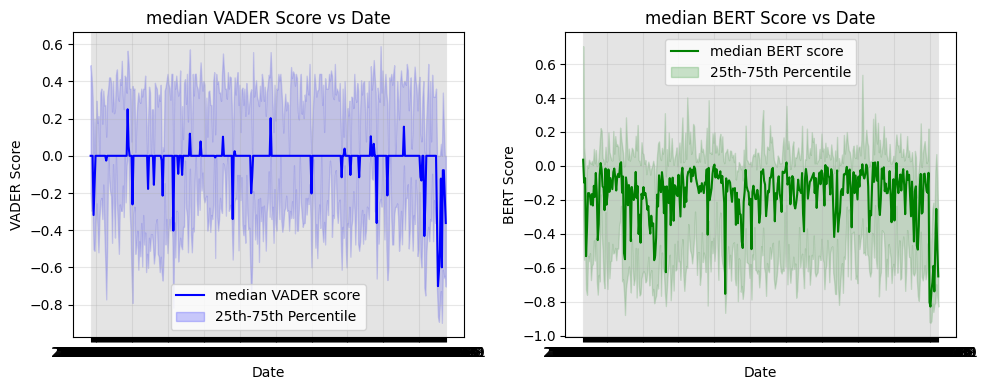

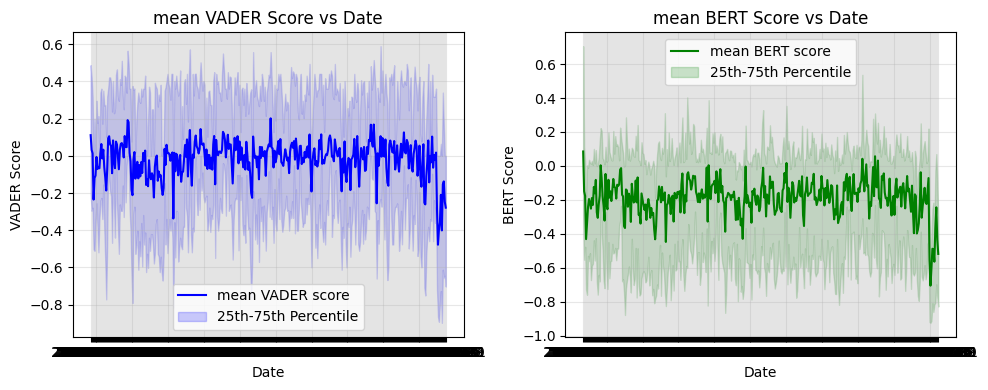

In [ ]:
summary = df_tweets_sentiment.groupby('date').agg(
    vader_median=('VADER_score', 'median'),
    vader_mean=('VADER_score', 'mean'),
    vader_q25=('VADER_score', lambda x: np.percentile(x, 25)),
    vader_q75=('VADER_score', lambda x: np.percentile(x, 75)),
    bert_median=('BERT_score', 'median'),
    bert_mean=('BERT_score', 'mean'),
    bert_q25=('BERT_score', lambda x: np.percentile(x, 25)),
    bert_q75=('BERT_score', lambda x: np.percentile(x, 75)),
    overall_median=('overall_sentiment', 'median'),
    overall_mean=('overall_sentiment', 'mean'),
    overall_q25=('overall_sentiment', lambda x: np.percentile(x, 25)),
    overall_q75=('overall_sentiment', lambda x: np.percentile(x, 75))
).reset_index()


def plot_sentiment(metric):
  feature_vader = "vader_"+metric
  feature_bert = "bert_"+metric
  label_vader_line = metric+" VADER score"
  label_bert_line = metric+" BERT score"

  fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharex=True)

  axs[0].plot(summary['date'], summary[feature_vader], label=label_vader_line, color='blue')
  axs[0].fill_between(summary['date'], summary['vader_q25'], summary['vader_q75'],
                   color='blue', alpha=0.2, label='25th-75th Percentile')
  axs[0].set_ylabel('VADER Score')
  axs[0].set_title(f'{metric} VADER Score vs Date')
  axs[0].set_xlabel('Date')
  axs[0].legend()
  axs[0].grid(True, alpha=0.3)

  axs[1].plot(summary['date'], summary[feature_bert], label=label_bert_line, color='green')
  axs[1].fill_between(summary['date'], summary['bert_q25'], summary['bert_q75'],
                   color='green', alpha=0.2, label='25th-75th Percentile')
  axs[1].set_ylabel('BERT Score')
  axs[1].set_title(f'{metric} BERT Score vs Date')
  axs[1].set_xlabel('Date')
  axs[1].legend()
  axs[1].grid(True, alpha=0.3)

  plt.tight_layout()
  plt.show()

plot_sentiment('median')
plot_sentiment('mean')

[]

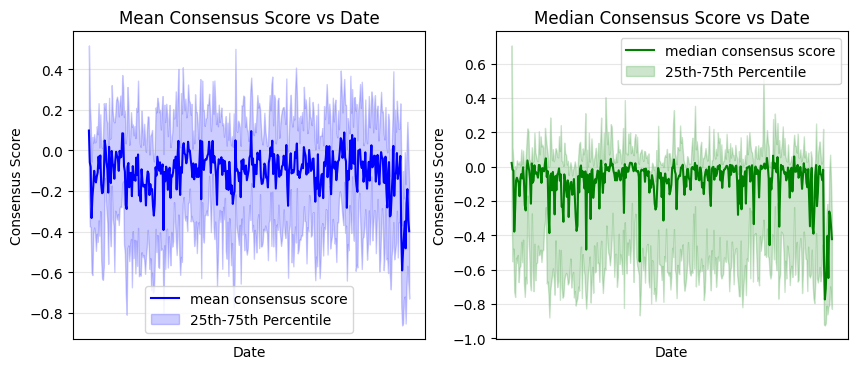

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharex=True)

axs[0].plot(summary['date'], summary['overall_mean'], label="mean consensus score", color='blue')
axs[0].fill_between(summary['date'], summary['overall_q25'], summary['overall_q75'],
                 color='blue', alpha=0.2, label='25th-75th Percentile')
axs[0].set_ylabel('Consensus Score')
axs[0].set_title(f'Mean Consensus Score vs Date')
axs[0].set_xlabel('Date')
axs[0].legend()
axs[0].grid(True, alpha=0.3)
axs[0].set_xticks([])  # Remove x-axis ticks
axs[0].set_xticklabels([])  # Remove x-axis labels

axs[1].plot(summary['date'], summary['overall_median'], label="median consensus score", color='green')
axs[1].fill_between(summary['date'], summary['bert_q25'], summary['bert_q75'],
                 color='green', alpha=0.2, label='25th-75th Percentile')
axs[1].set_ylabel('Consensus Score')
axs[1].set_title(f'Median Consensus Score vs Date')
axs[1].set_xlabel('Date')
axs[1].legend()
axs[1].grid(True, alpha=0.3)
axs[1].set_xticks([])  # Remove x-axis ticks
axs[1].set_xticklabels([])  # Remove x-axis labels


In [ ]:

# we now get the 10 dates with the max overall negative/positive sentiment

overall_most_positive = summary.nlargest(36, 'overall_mean')['date'].tolist()
overall_most_negative = summary.nsmallest(18, 'overall_mean')['date'].tolist()

pos_discourse_dates = list(set(overall_most_positive) & set(top_unique_all))
neg_discourse_dates = list(set(overall_most_negative) & set(top_unique_all))

print("These are the dates present in the top 10 %ile of one of Twitter's activity metrics, \nand with the top 10 %ile most positive content: ")
print(pos_discourse_dates)
print('\n')

print("These are the dates present in the top 10 %ile of one of Twitter's activity metrics, \nand with the top 5 %ile most negative content: ")
print(neg_discourse_dates)

These are the dates present in the top 10 %ile of one of Twitter's activity metrics, 
and with the top 10 %ile most positive content: 
['2024-04-18', '2024-08-25', '2024-02-09', '2024-10-25', '2024-12-13', '2024-09-02']


These are the dates present in the top 10 %ile of one of Twitter's activity metrics, 
and with the top 5 %ile most negative content: 
['2024-03-15', '2024-12-09', '2024-12-25', '2024-12-06', '2024-03-26', '2024-12-30', '2024-12-23', '2024-03-14', '2024-12-24', '2024-12-27', '2024-12-22', '2024-01-04']


In [ ]:
import yake

def yake_keyword_extraction(date):
  df=df_tweets[df_tweets['Date']==date]
  tweets=df['cleaned'].tolist()
  text = " ".join(tweets)
  language = "en"
  max_ngram_size = 2
  deduplication_threshold = 0.6
  numOfKeywords = 20
  custom_kw_extractor = yake.KeywordExtractor(lan=language, n=max_ngram_size, dedupLim=deduplication_threshold, top=numOfKeywords, features=None)
  keywords = custom_kw_extractor.extract_keywords(text)
  return keywords


In [ ]:
positive_keywords = [a[0] for a in yake_keyword_extraction('2024-10-25')[:10]]
print(positive_keywords)

negative_keywords = [a[0] for a in yake_keyword_extraction('2024-03-26')[:10]]
print(negative_keywords)

['nyc subway', 'fatal nyc', 'wont easy', 'easy convict', 'admits wont', 'convict daniel', 'daniel penny', 'penny fatal', 'subway chokehold', 'day nyc']
['nyc subway', 'pushed front', 'subway violence', 'subway rider', 'fatally pushed', 'man fatally', 'subway shove', 'front train', 'fatal nyc', 'perfectly pushed']


In [ ]:
df_mta = df_mta.rename(columns={'transit_date': 'Date'})
df_mta

Date          station_complex    borough  ridership  \
0       2023-12-01                 1 Av (L)  Manhattan      19046   
1       2023-12-01               103 St (1)  Manhattan       9600   
2       2023-12-01               103 St (6)  Manhattan       8634   
3       2023-12-01             103 St (C,B)  Manhattan       3329   
4       2023-12-01  103 St-Corona Plaza (7)     Queens      21665   
...            ...                      ...        ...        ...   
169613  2024-12-31     Woodhaven Blvd (J,Z)     Queens       2535   
169614  2024-12-31     Woodhaven Blvd (M,R)     Queens      11271   
169615  2024-12-31             Woodlawn (4)      Bronx       3245   
169616  2024-12-31              York St (F)   Brooklyn       9471   
169617  2024-12-31            Zerega Av (6)      Bronx       1186   

                        georeference  
0        POINT (-73.98163 40.730953)  
1       POINT (-73.968376 40.799446)  
2          POINT (-73.94748 40.7906)  
3        POINT (-73.96146 40.796093)  
4         POINT (-73.8627 40.749866)  
...                              ...  
169613    POINT (-73.85158 40.69388)  
169614   POINT (-73.86923 40.733105)  
169615   POINT (-73.87875 40.886036)  
169616   POINT (-73.98675 40.701397)  
169617   POINT (-73.84704 40.836487)  

[169618 rows x 5 columns]

In [ ]:
df=df_mta.merge(df_tweets, on='Date')
df

Date station_complex    borough  ridership  \
0         2024-01-01        1 Av (L)  Manhattan       8940   
1         2024-01-01        1 Av (L)  Manhattan       8940   
2         2024-01-01        1 Av (L)  Manhattan       8940   
3         2024-01-01        1 Av (L)  Manhattan       8940   
4         2024-01-01        1 Av (L)  Manhattan       8940   
...              ...             ...        ...        ...   
14758522  2024-12-31   Zerega Av (6)      Bronx       1186   
14758523  2024-12-31   Zerega Av (6)      Bronx       1186   
14758524  2024-12-31   Zerega Av (6)      Bronx       1186   
14758525  2024-12-31   Zerega Av (6)      Bronx       1186   
14758526  2024-12-31   Zerega Av (6)      Bronx       1186   

                         georeference  \
0         POINT (-73.98163 40.730953)   
1         POINT (-73.98163 40.730953)   
2         POINT (-73.98163 40.730953)   
3         POINT (-73.98163 40.730953)   
4         POINT (-73.98163 40.730953)   
...                               ...   
14758522  POINT (-73.84704 40.836487)   
14758523  POINT (-73.84704 40.836487)   
14758524  POINT (-73.84704 40.836487)   
14758525  POINT (-73.84704 40.836487)   
14758526  POINT (-73.84704 40.836487)   

                                                    cleaned  Comments  \
0                                                nyc subway       2.0   
1                                normal day new york subway       0.0   
2                                          kurdish problems       0.0   
3         happy new year wherever world may 2024 bring l...       1.0   
4         lovely scene siblings perform auld lang syne n...       0.0   
...                                                     ...       ...   
14758522  police woman burned alive nyc subway identifie...       0.0   
14758523  ride nyc subway said safe said cost big bucks ...       0.0   
14758524  trigger warning violent videomta negligent ins...       0.0   
14758525  man shoved onto nyc subway tracks broad daylig...       0.0   
14758526  hill correction man mysteriously falls front n...       0.0   

          Retweets  Likes  Analytics  vader_score  negative   neutral  \
0              8.0   55.0     1400.0       0.0000  0.134240  0.728712   
1              0.0    0.0      342.0       0.0000  0.014265  0.655943   
2              0.0    1.0      143.0      -0.4019  0.482487  0.494562   
3             16.0   56.0     6600.0       0.9118  0.000919  0.030470   
4              0.0    3.0     1500.0       0.9300  0.001573  0.068745   
...            ...    ...        ...          ...       ...       ...   
14758522       0.0    1.0      235.0       0.3818  0.700212  0.293543   
14758523      23.0   99.0     1600.0       0.1280  0.367127  0.581052   
14758524       0.0    1.0       74.0      -0.7430  0.711799  0.279719   
14758525       0.0    0.0       33.0       0.0000  0.323216  0.642106   
14758526       0.0    0.0       64.0       0.1280  0.348462  0.625957   

          positive  nlp_sentiment_normalized  overall_sentiment  net_sentiment  
0         0.137048                 -0.002502          -0.001251       0.002808  
1         0.329793                  0.314687           0.157343       0.315528  
2         0.022951                 -0.471454          -0.436677      -0.459536  
3         0.968611                  0.976172           0.943986       0.967692  
4         0.929681                  0.936022           0.933011       0.928108  
...            ...                       ...                ...            ...  
14758522  0.006246                 -0.709235          -0.163717      -0.693966  
14758523  0.051821                 -0.325164          -0.098582      -0.315307  
14758524  0.008481                 -0.718720          -0.730860      -0.703318  
14758525  0.034678                 -0.298011          -0.149006      -0.288537  
14758526  0.025581                 -0.332846          -0.102423      -0.322881  

[14758527 rows x 17 columns]

In [ ]:
from shapely import wkt
df_mta['geometry'] = df_mta['georeference'].apply(wkt.loads)

Extracting 'nybb_16a/nybb.shp' from '/root/.cache/geodatasets/nybb_16a.zip' to '/root/.cache/geodatasets/nybb_16a.zip.unzip'
Extracting 'nybb_16a/nybb.shx' from '/root/.cache/geodatasets/nybb_16a.zip' to '/root/.cache/geodatasets/nybb_16a.zip.unzip'
Extracting 'nybb_16a/nybb.dbf' from '/root/.cache/geodatasets/nybb_16a.zip' to '/root/.cache/geodatasets/nybb_16a.zip.unzip'
Extracting 'nybb_16a/nybb.prj' from '/root/.cache/geodatasets/nybb_16a.zip' to '/root/.cache/geodatasets/nybb_16a.zip.unzip'


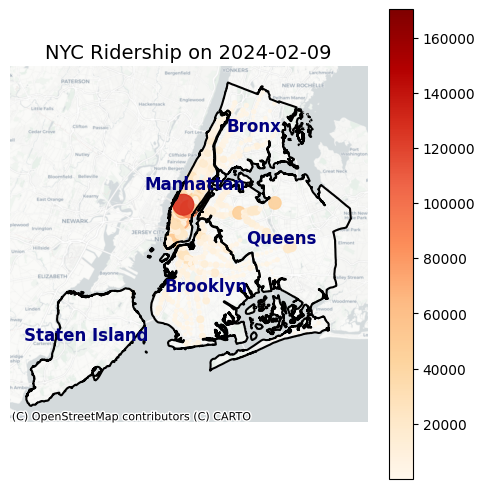

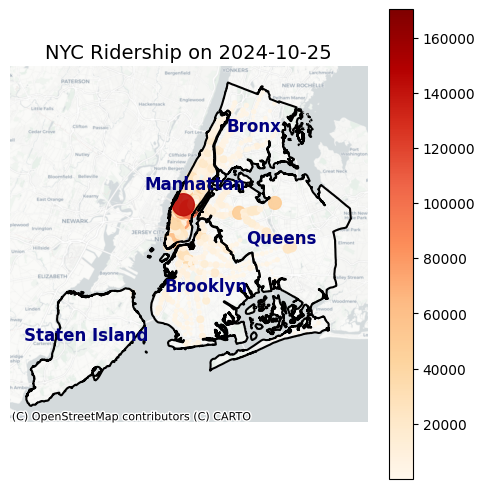

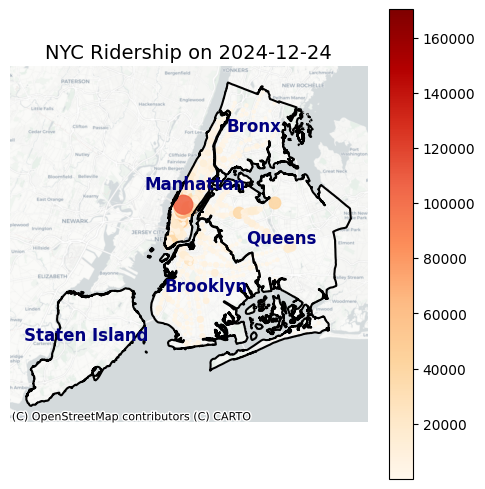

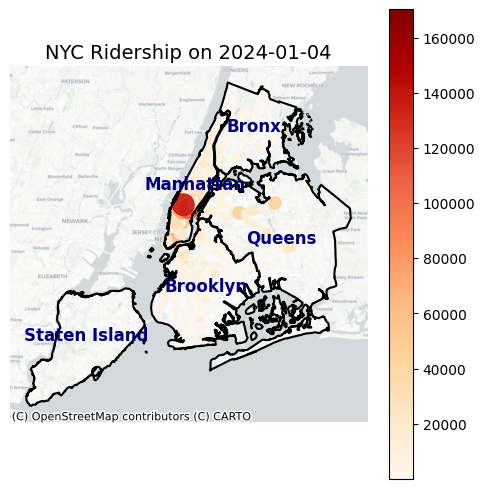

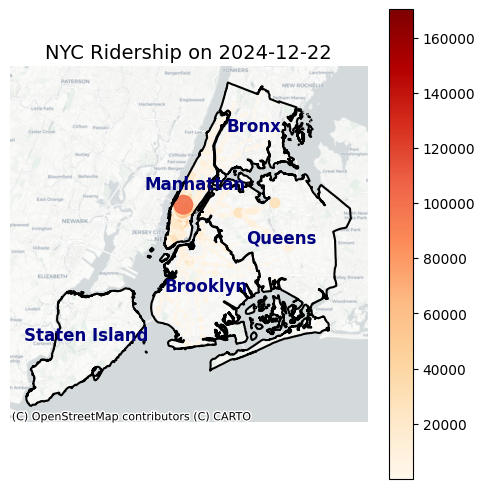

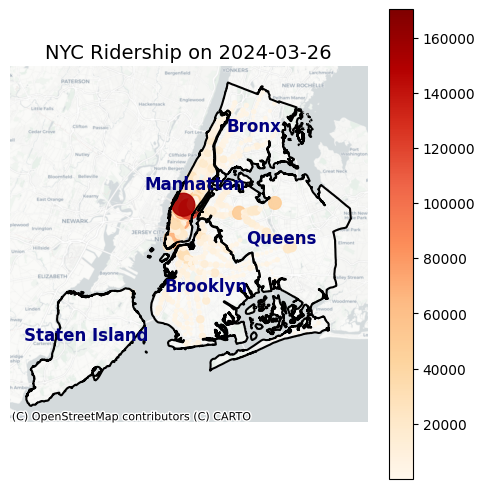

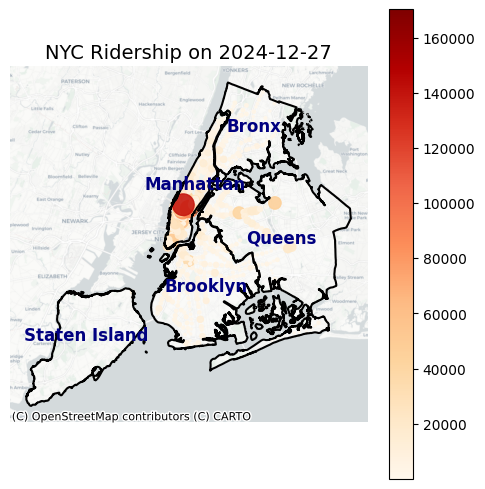

In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import contextily as ctx
from shapely import wkt
from geodatasets import get_path

# Convert to GeoDataFrame
gdf_mta = gpd.GeoDataFrame(df_mta, geometry='geometry', crs='EPSG:4326').to_crs(epsg=3857)

# Load NYC boroughs
nyc_boroughs = gpd.read_file(get_path('nybb')).to_crs(epsg=3857)

# Ensure date column is datetime
gdf_mta['Date'] = pd.to_datetime(gdf_mta['Date'])

# Dates of interest
dates_of_interest = ['2024-02-09', '2024-10-25', '2024-12-24', '2024-01-04', '2024-12-22', '2024-03-26', '2024-12-27']

# Set global min/max ridership for consistent color scale
vmin = gdf_mta['ridership'].min()
vmax = gdf_mta['ridership'].max()

# Plot one map per date
for date in dates_of_interest:
    gdf_day = gdf_mta[gdf_mta['Date'] == pd.to_datetime(date)]

    if gdf_day.empty:
        print(f"No data for {date}")
        continue

    fig, ax = plt.subplots(figsize=(5, 5))
    nyc_boroughs.boundary.plot(ax=ax, color='black')

    gdf_day.plot(
        ax=ax,
        column='ridership',
        cmap='OrRd',
        markersize=gdf_day['ridership'] / vmax * 300,
        alpha=0.9,                      # Darker points
        legend=True,
        vmin=vmin,                     # Fixed color scale
        vmax=vmax
    )

    for _, row in nyc_boroughs.iterrows():
        ax.annotate(row['BoroName'], xy=(row.geometry.centroid.x, row.geometry.centroid.y),
                    ha='center', fontsize=12, fontweight='bold', color='navy')

    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

    ax.set_title(f'NYC Ridership on {date}', fontsize=14)
    ax.set_axis_off()
    plt.tight_layout()
    plt.show()



In [ ]:
df_mta_daily=df_mta[['Date', 'ridership']].groupby('Date').sum()
df_daily=df_mta_daily.merge(df_tweets, on='Date')
df_daily

Date  ridership  \
0      2024-01-01    1673372   
1      2024-01-01    1673372   
2      2024-01-01    1673372   
3      2024-01-01    1673372   
4      2024-01-01    1673372   
...           ...        ...   
34539  2024-12-31    2929473   
34540  2024-12-31    2929473   
34541  2024-12-31    2929473   
34542  2024-12-31    2929473   
34543  2024-12-31    2929473   

                                                 cleaned  Comments  Retweets  \
0                                             nyc subway       2.0       8.0   
1                             normal day new york subway       0.0       0.0   
2                                       kurdish problems       0.0       0.0   
3      happy new year wherever world may 2024 bring l...       1.0      16.0   
4      lovely scene siblings perform auld lang syne n...       0.0       0.0   
...                                                  ...       ...       ...   
34539  police woman burned alive nyc subway identifie...       0.0       0.0   
34540  ride nyc subway said safe said cost big bucks ...       0.0      23.0   
34541  trigger warning violent videomta negligent ins...       0.0       0.0   
34542  man shoved onto nyc subway tracks broad daylig...       0.0       0.0   
34543  hill correction man mysteriously falls front n...       0.0       0.0   

       Likes  Analytics  vader_score  negative   neutral  positive  \
0       55.0     1400.0       0.0000  0.134240  0.728712  0.137048   
1        0.0      342.0       0.0000  0.014265  0.655943  0.329793   
2        1.0      143.0      -0.4019  0.482487  0.494562  0.022951   
3       56.0     6600.0       0.9118  0.000919  0.030470  0.968611   
4        3.0     1500.0       0.9300  0.001573  0.068745  0.929681   
...      ...        ...          ...       ...       ...       ...   
34539    1.0      235.0       0.3818  0.700212  0.293543  0.006246   
34540   99.0     1600.0       0.1280  0.367127  0.581052  0.051821   
34541    1.0       74.0      -0.7430  0.711799  0.279719  0.008481   
34542    0.0       33.0       0.0000  0.323216  0.642106  0.034678   
34543    0.0       64.0       0.1280  0.348462  0.625957  0.025581   

       nlp_sentiment_normalized  overall_sentiment  net_sentiment  
0                     -0.002502          -0.001251       0.002808  
1                      0.314687           0.157343       0.315528  
2                     -0.471454          -0.436677      -0.459536  
3                      0.976172           0.943986       0.967692  
4                      0.936022           0.933011       0.928108  
...                         ...                ...            ...  
34539                 -0.709235          -0.163717      -0.693966  
34540                 -0.325164          -0.098582      -0.315307  
34541                 -0.718720          -0.730860      -0.703318  
34542                 -0.298011          -0.149006      -0.288537  
34543                 -0.332846          -0.102423      -0.322881  

[34544 rows x 14 columns]

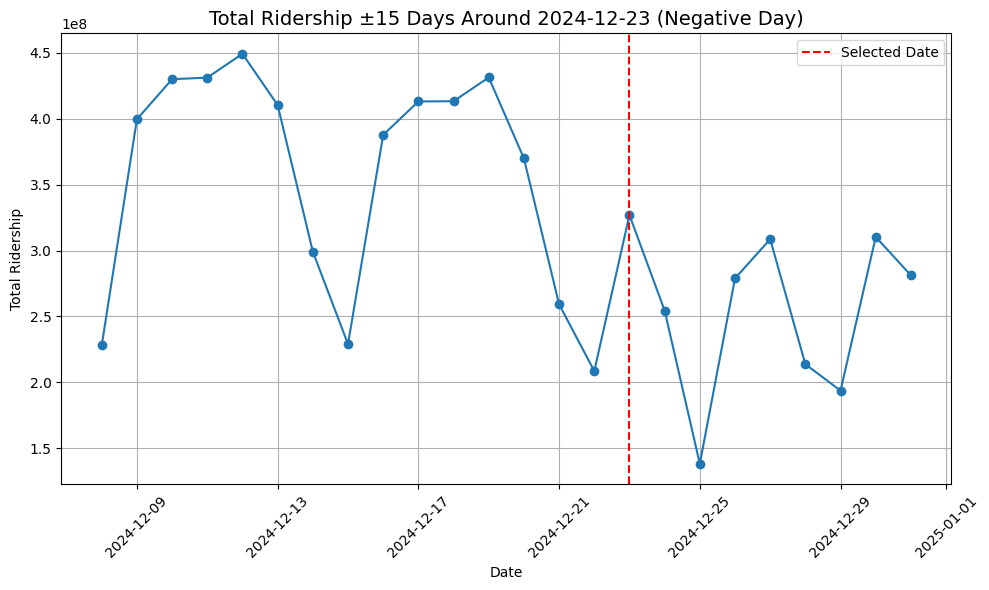

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure 'Date' is datetime
df_daily['Date'] = pd.to_datetime(df_daily['Date'])

# Step 1: Choose your selected date
selected_date = pd.to_datetime('2024-12-23')  # You can change this

# Step 2: Filter for ±15 days
mask = (df_daily['Date'] >= selected_date - pd.Timedelta(days=15)) & \
       (df_daily['Date'] <= selected_date + pd.Timedelta(days=15))
df_window = df_daily[mask]

# Step 3: Aggregate total ridership per day
daily_totals = df_window.groupby('Date')['ridership'].sum().reset_index()

# Step 4: Plot
plt.figure(figsize=(10, 6))
plt.plot(daily_totals['Date'], daily_totals['ridership'], marker='o')
plt.axvline(selected_date, color='red', linestyle='--', label='Selected Date')
plt.title(f'Total Ridership ±15 Days Around {selected_date.date()} (Negative Day)', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Total Ridership')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('neg_img')

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure 'Date' is datetime
df_daily['Date'] = pd.to_datetime(df_daily['Date'])

# Step 1: Choose your selected date
selected_date = pd.to_datetime('2024-12-24')  # You can change this

# Step 2: Filter for ±15 days
mask = (df_daily['Date'] >= selected_date - pd.Timedelta(days=15)) & \
       (df_daily['Date'] <= selected_date + pd.Timedelta(days=15))
df_window = df_daily[mask]

# Step 3: Aggregate total ridership per day
daily_totals = df_window.groupby('Date')['ridership'].sum().reset_index()

# Step 4: Plot
plt.figure(figsize=(5, 5))
plt.plot(daily_totals['Date'], daily_totals['ridership'], marker='o')
plt.axvline(selected_date, color='red', linestyle='--', label='Selected Date')
plt.title(f'Total Ridership ±15 Days Around {selected_date.date()}', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Total Ridership')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

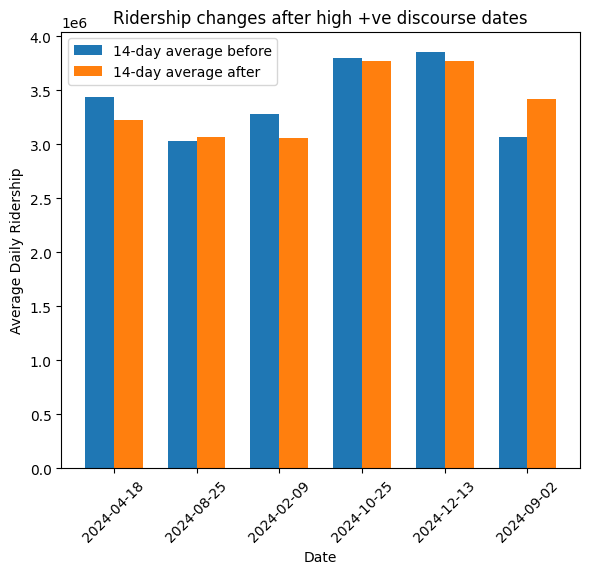

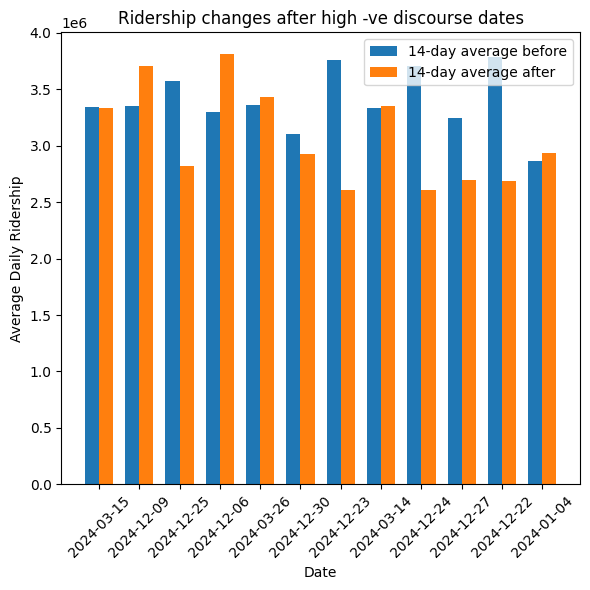

In [ ]:
df_mta_daily

cumulative_before = []
cumulative_after = []
average_before = []
average_after = []

pos_dates = pd.to_datetime(pos_discourse_dates)
neg_dates = pd.to_datetime(neg_discourse_dates)

for selected_date in pos_dates:
    mask_before = (df_daily['Date'] >= selected_date - pd.Timedelta(days=7)) & (df_daily['Date'] < selected_date)
    mask_after = (df_daily['Date'] > selected_date) & (df_daily['Date'] <= selected_date + pd.Timedelta(days=7))

    cum_before = df_daily.loc[mask_before, 'ridership'].sum()
    cum_after = df_daily.loc[mask_after, 'ridership'].sum()
    avg_before = df_daily.loc[mask_before, 'ridership'].mean()
    avg_after = df_daily.loc[mask_after, 'ridership'].mean()

    cumulative_before.append(cum_before)
    cumulative_after.append(cum_after)
    average_before.append(avg_before)
    average_after.append(avg_after)

results_df_pos = pd.DataFrame({
    'Date': pos_dates,
    'Cumulative Before': cumulative_before,
    'Cumulative After': cumulative_after,
    'Average Before': average_before,
    'Average After': average_after
})

cumulative_before = []
cumulative_after = []
average_before = []
average_after = []

for selected_date in neg_dates:
    mask_before = (df_daily['Date'] >= selected_date - pd.Timedelta(days=14)) & (df_daily['Date'] < selected_date)
    mask_after = (df_daily['Date'] > selected_date) & (df_daily['Date'] <= selected_date + pd.Timedelta(days=14))

    cum_before = df_daily.loc[mask_before, 'ridership'].sum()
    cum_after = df_daily.loc[mask_after, 'ridership'].sum()
    avg_before = df_daily.loc[mask_before, 'ridership'].mean()
    avg_after = df_daily.loc[mask_after, 'ridership'].mean()

    cumulative_before.append(cum_before)
    cumulative_after.append(cum_after)
    average_before.append(avg_before)
    average_after.append(avg_after)

results_df_neg = pd.DataFrame({
    'Date': neg_dates,
    'Cumulative Before': cumulative_before,
    'Cumulative After': cumulative_after,
    'Average Before': average_before,
    'Average After': average_after
})


fig, ax = plt.subplots(figsize=(6, 6))
bar_width = 0.35
index = range(len(results_df_pos))

ax.bar([i - bar_width/2 for i in index], results_df_pos['Average Before'], bar_width, label='14-day average before')
ax.bar([i + bar_width/2 for i in index], results_df_pos['Average After'], bar_width, label='14-day average after')

ax.set_xlabel('Date')
ax.set_ylabel('Average Daily Ridership')
ax.set_title('Ridership changes after high +ve discourse dates')
ax.set_xticks(index)
ax.set_xticklabels(results_df_pos['Date'].dt.strftime('%Y-%m-%d'), rotation=45)
ax.legend()

plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(6, 6))
bar_width = 0.35
index = range(len(results_df_neg))

ax.bar([i - bar_width/2 for i in index], results_df_neg['Average Before'], bar_width, label='14-day average before')
ax.bar([i + bar_width/2 for i in index], results_df_neg['Average After'], bar_width, label='14-day average after')

ax.set_xlabel('Date')
ax.set_ylabel('Average Daily Ridership')
ax.set_title('Ridership changes after high -ve discourse dates')
ax.set_xticks(index)
ax.set_xticklabels(results_df_neg['Date'].dt.strftime('%Y-%m-%d'), rotation=45)
ax.legend()

plt.tight_layout()
plt.show()



In [ ]:


gdf_mta = gpd.GeoDataFrame(df_mta, geometry='geometry', crs='EPSG:4326').to_crs(epsg=3857)
nyc_boroughs = gpd.read_file(get_path('nybb')).to_crs(epsg=3857)

gdf_mta['Date']

0         2023-12-01
1         2023-12-01
2         2023-12-01
3         2023-12-01
4         2023-12-01
             ...    
169613    2024-12-31
169614    2024-12-31
169615    2024-12-31
169616    2024-12-31
169617    2024-12-31
Name: Date, Length: 169618, dtype: object

KeyboardInterrupt: 

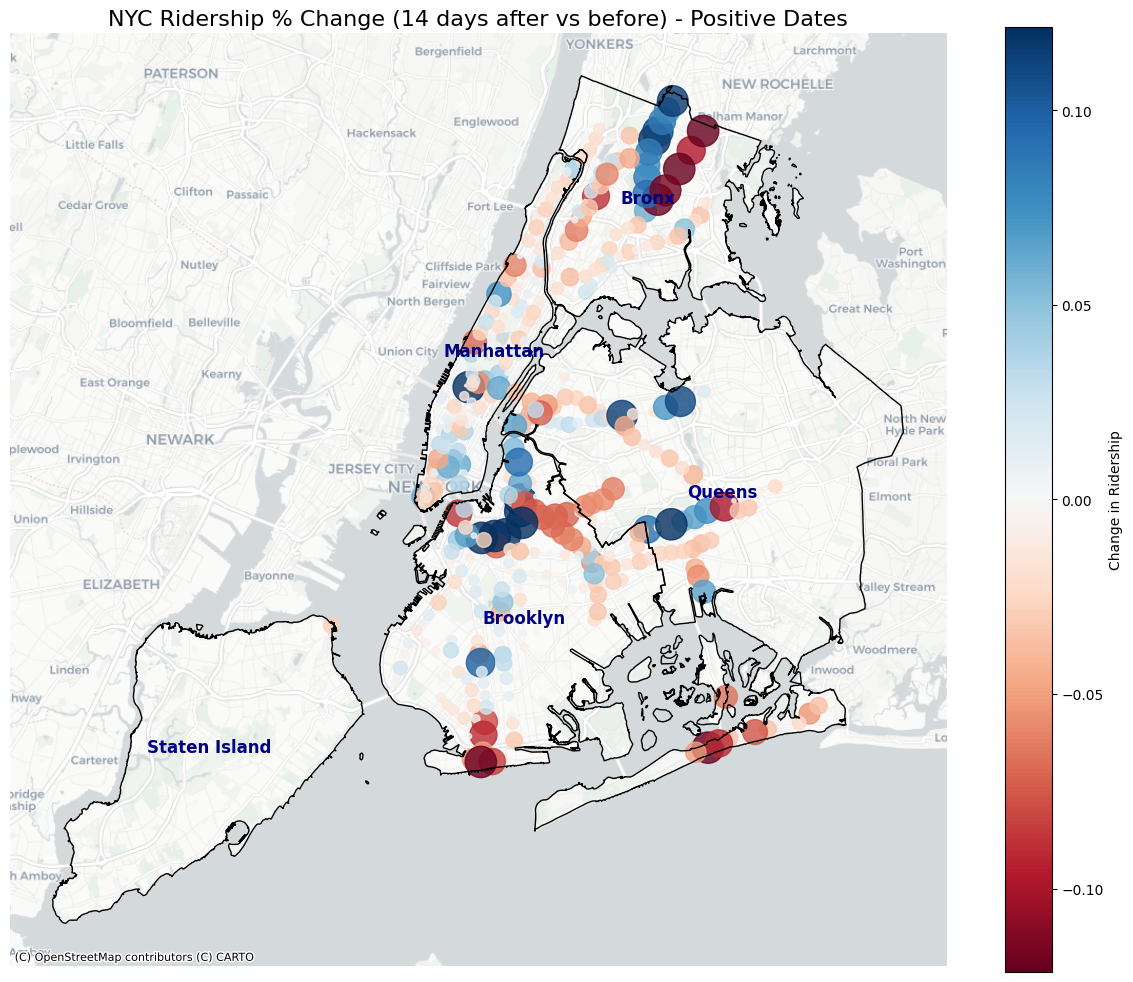

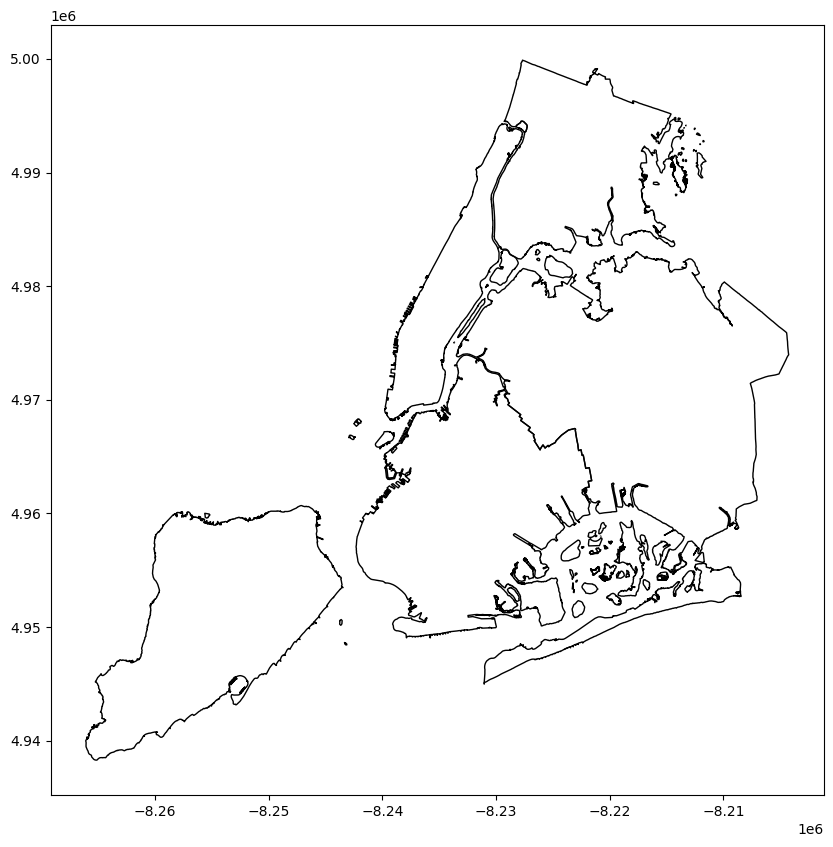

In [ ]:
def calculate_ridership_change(dates, gdf):
    station_changes = {}

    for date in dates:
        date = pd.to_datetime(date)

        before_start = date - pd.Timedelta(days=14)
        after_end = date + pd.Timedelta(days=14)

        gdf['Date'] = pd.to_datetime(gdf['Date'])
        stations = gdf[(gdf['Date'] >= before_start) &
                     (gdf['Date'] <= after_end)]['station_complex'].unique()

        for station in stations:
            station_data = gdf[gdf['station_complex'] == station]
            before_avg = station_data[(station_data['Date'] >= before_start) &
                                    (station_data['Date'] < date)]['ridership'].mean()

            after_avg = station_data[(station_data['Date'] > date) &
                                   (station_data['Date'] <= after_end)]['ridership'].mean()

            if pd.notna(before_avg) and pd.notna(after_avg):
                change = (after_avg - before_avg)/before_avg

                if station not in station_changes:
                    station_changes[station] = []

                station_changes[station].append(change)

    avg_changes = {}
    for station, changes in station_changes.items():
        avg_changes[station] = np.mean(changes)

    return avg_changes

positive_changes = calculate_ridership_change(pos_dates, gdf_mta)
negative_changes = calculate_ridership_change(neg_dates, gdf_mta)

def plot_ridership_change_map(changes, title, cmap='RdBu'):
    fig, ax = plt.subplots(figsize=(12, 10))

    # Plot borough boundaries
    nyc_boroughs.boundary.plot(ax=ax, color='black', linewidth=1)

    # Create a temporary dataframe with changes
    change_data = []
    for station, change in changes.items():
        # Get the station geometry (first occurrence)
        station_geo = gdf_mta[gdf_mta['station_complex'] == station].iloc[0]['geometry']
        borough = gdf_mta[gdf_mta['station_complex'] == station].iloc[0]['borough']
        change_data.append({
            'station_complex': station,
            'change': change,
            'borough': borough,
            'geometry': station_geo
        })

    if not change_data:
        print(f"No data available for {title}")
        return

    # Create GeoDataFrame
    change_gdf = gpd.GeoDataFrame(change_data, geometry='geometry', crs=gdf_mta.crs)

    # Calculate marker size based on absolute change
    max_change = max(abs(min(changes.values())), abs(max(changes.values())))
    values = list(changes.values())
    maxish_change = np.percentile(np.abs(values), 90)
    vmin = -(maxish_change+0.05)
    vmax = maxish_change+0.05

    change_gdf['change'] = change_gdf['change'].clip(lower=vmin, upper=vmax)
    change_gdf['marker_size'] = change_gdf['change'].abs() / maxish_change * 300


    # Plot the changes
    change_gdf.plot(
        ax=ax,
        column='change',
        cmap=cmap,
        markersize=change_gdf['marker_size'],
        alpha=0.8,
        legend=True,
        vmin=vmin,
        vmax=vmax,
        legend_kwds={'label': 'Change in Ridership'}
    )

    # Add borough labels
    for _, row in nyc_boroughs.iterrows():
        ax.annotate(row['BoroName'], xy=(row.geometry.centroid.x, row.geometry.centroid.y),
                   ha='center', fontsize=12, fontweight='bold', color='navy')

    # Add basemap
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

    # Add title and legend
    ax.set_title(title, fontsize=16)
    ax.set_axis_off()

    plt.tight_layout()
    return fig, ax

# Plot the maps
pos_fig, pos_ax = plot_ridership_change_map(
    positive_changes,
    'NYC Ridership % Change (14 days after vs before) - Positive Dates'
)

neg_fig, neg_ax = plot_ridership_change_map(
    negative_changes,
    'NYC Ridership % Change (14 days after vs before) - Negative Dates'
)

plt.show()

In [ ]:

most_drop = dict(sorted(negative_changes.items(), key=lambda item: item[1]))
print("The five stations with the highest % drop are:")
for key in list(most_drop.keys())[:5]:
  print("-",key)

In [ ]:
df_mta_borough = df_mta[['Date', 'borough', 'ridership']].groupby(['Date', 'borough']).sum().reset_index()
df_mta_borough


In [ ]:
def calculate_ridership_change_borough(dates, gdf):
    boro_changes = {}

    for date in dates:
        date = pd.to_datetime(date)

        before_start = date - pd.Timedelta(days=14)
        after_end = date + pd.Timedelta(days=14)

        gdf['Date'] = pd.to_datetime(gdf['Date'])
        boroughs = ['Bronx','Brooklyn','Manhattan','Queens','Staten Island']

        for boro in boroughs:
            boro_data = gdf[gdf['borough'] == boro]
            before_avg = boro_data[(boro_data['Date'] >= before_start) &
                                    (boro_data['Date'] < date)]['ridership'].mean()

            after_avg = boro_data[(boro_data['Date'] > date) &
                                   (boro_data['Date'] <= after_end)]['ridership'].mean()

            if pd.notna(before_avg) and pd.notna(after_avg):
                change = (after_avg - before_avg)/before_avg

                if boro not in boro_changes:
                    boro_changes[boro] = []

                boro_changes[boro].append(change)

    avg_boro_changes = {}
    for boro, changes in boro_changes.items():
        avg_boro_changes[boro] = np.mean(changes)

    return avg_boro_changes

positive_changes_boro = calculate_ridership_change_borough(pos_dates, df_mta_borough)
negative_changes_boro = calculate_ridership_change_borough(neg_dates, df_mta_borough)


In [ ]:
from matplotlib.colors import TwoSlopeNorm


df_pos = pd.DataFrame(list(positive_changes_boro.items()), columns=['BoroName', 'change'])
df_neg = pd.DataFrame(list(negative_changes_boro.items()), columns=['BoroName', 'change'])

pos_gdf = nyc_boroughs.merge(df_pos, on='BoroName', how='left')
neg_gdf = nyc_boroughs.merge(df_neg, on='BoroName', how='left')

fig, axes = plt.subplots(figsize=(8, 8))

neg_gdf.plot(column='change', cmap='Reds_r', linewidth=0.8, ax=axes, edgecolor='black', legend=True)
axes.set_title('Ridership Changes by Borough (after -ve discourse)')
plt.axis('off')

plt.show()
